# Практикум №3: Зниження розмірності набору даних, отримання суттєвих ознак (feature extraction)

1. Опрацювати матеріали уроків U-6, U-7, U-8. Імпорт залежностей.

In [1]:
import torch
import random
import pandas as pd
import numpy as np

from torch import nn
from torch import optim

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import (
    PCA,
    IncrementalPCA,
    SparsePCA,
    KernelPCA,
    DictionaryLearning,
    FactorAnalysis,
    FastICA,
)

from src.visualization.plot import plot_feature_count_to_f1
from src.model.mpl_auto_encoder import AutoEncoder, LinearAutoEncoder
from src.trainer.auto_encoder_trainer import AutoEncoderTrainer

random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

2. Обрати одну з наступних задач та відповідно набір даних з багатьма ознаками:

* Зменшення розмірності табличних даних. 
* Усунення шумів у зображеннях і реконструкція зображень. Оцінювання джерел із зашумлених вимірів.
* Отримання ознак (feature extraction) із наборів зображень.
* Отримання тем з наборів тексту (topic extraction).

Дані для навчання можна обрати з репозиторію машинного навчання UCI: https://archive.ics.uci.edu/datasets.

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/static/public/45/data.csv")

features_count = len(df.columns) - 1

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
df = df.dropna()

In [4]:
x = df.drop(columns=["num"]).to_numpy(dtype=np.float32)
y = df["num"].to_numpy(dtype=np.float32)

3. Виконати зниження розмірності набору даних, отримати суттєві ознаки (feature extraction), усунути шуми та ін. (залежно від обраної задачі), використовуючи декілька алгоритмів, реалізованих в scikit-learn python, з наступного переліку: 

* Метод головних компонент (PCA)   
* Зростаючий метод головних компонент (Incremental PCA)
* PCA з рандомізованим розкладом за власними числами (singular value decomposition, SVD)
* Розріджений метод головних компонент (SparsePCA та MiniBatchSparsePCA)
* Ядерний метод головних компонент (Kernel PCA)
* Усічений SVD і скритий семантичний аналіз (Truncated singular value decomposition and latent semantic analysis)
* Словникове навчання (Dictionary Learning та MiniBatchDictionaryLearning)
* Факторний аналіз (Factor Analysis, FA)
* Аналіз незалежних компонент (Independent component analysis, ICA)
* Метод матричної факторизації (Non-negative matrix factorization (NMF або NNMF))
* Скритий розподіл Дирихле (Latent Dirichlet Allocation, LDA)
* Лінійний та квадратичний дискримінантний аналіз (Linear and Quadratic Discriminant Analysis) - задача навчання з вчителем. 

In [5]:
pipe = make_pipeline(
    PCA(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "pca__n_components": np.arange(4, features_count, 1),
    "pca__svd_solver": ["auto", "full", "covariance_eigh", "arpack", "randomized"]
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

print("Best score: " + str(search.best_score_))
print("Best params: " + str(search.best_params_))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5; 1/45] START pca__n_components=4, pca__svd_solver=auto..................
[CV 1/5; 1/45] END pca__n_components=4, pca__svd_solver=auto;, score=0.431 total time=   0.1s
[CV 2/5; 1/45] START pca__n_components=4, pca__svd_solver=auto..................
[CV 2/5; 1/45] END pca__n_components=4, pca__svd_solver=auto;, score=0.426 total time=   0.1s
[CV 3/5; 1/45] START pca__n_components=4, pca__svd_solver=auto..................
[CV 3/5; 1/45] END pca__n_components=4, pca__svd_solver=auto;, score=0.424 total time=   0.1s
[CV 4/5; 1/45] START pca__n_components=4, pca__svd_solver=auto..................
[CV 4/5; 1/45] END pca__n_components=4, pca__svd_solver=auto;, score=0.505 total time=   0.1s
[CV 5/5; 1/45] START pca__n_components=4, pca__svd_solver=auto..................
[CV 5/5; 1/45] END pca__n_components=4, pca__svd_solver=auto;, score=0.497 total time=   0.1s
[CV 1/5; 2/45] START pca__n_components=4, pca__svd_solver=full.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START incrementalpca__n_components=4..............................
[CV 1/5; 1/9] END incrementalpca__n_components=4;, score=0.431 total time=   0.1s
[CV 2/5; 1/9] START incrementalpca__n_components=4..............................
[CV 2/5; 1/9] END incrementalpca__n_components=4;, score=0.426 total time=   0.1s
[CV 3/5; 1/9] START incrementalpca__n_components=4..............................
[CV 3/5; 1/9] END incrementalpca__n_components=4;, score=0.424 total time=   0.0s
[CV 4/5; 1/9] START incrementalpca__n_components=4..............................
[CV 4/5; 1/9] END incrementalpca__n_components=4;, score=0.505 total time=   0.1s
[CV 5/5; 1/9] START incrementalpca__n_components=4..............................
[CV 5/5; 1/9] END incrementalpca__n_components=4;, score=0.497 total time=   0.1s
[CV 1/5; 2/9] START incrementalpca__n_components=5..............................
[CV 1/5; 2/9] END incrementalpca__n_componen

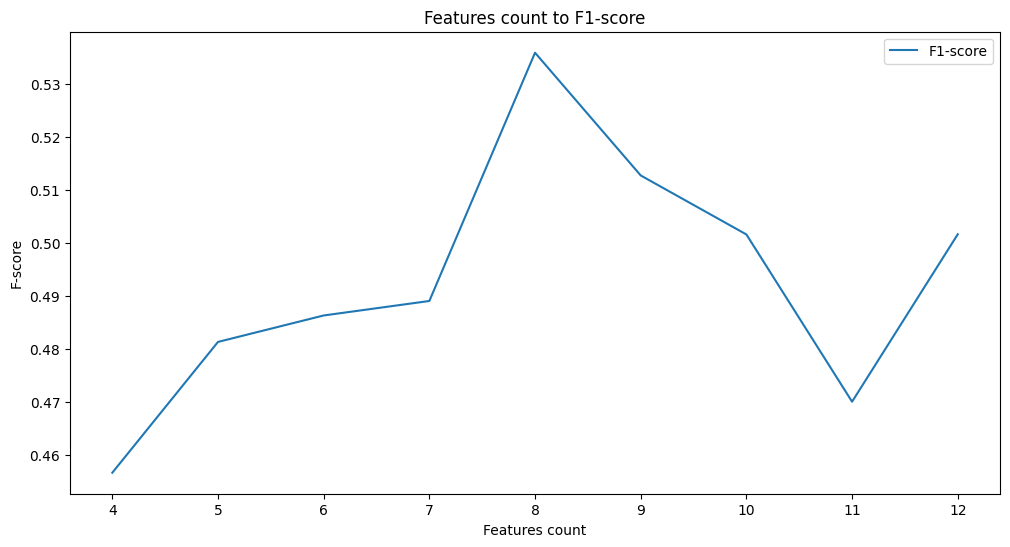

In [6]:
pipe = make_pipeline(
    IncrementalPCA(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "incrementalpca__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["incrementalpca__n_components"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START sparsepca__n_components=4...................................
[CV 1/5; 1/9] END ....sparsepca__n_components=4;, score=0.392 total time=   0.2s
[CV 2/5; 1/9] START sparsepca__n_components=4...................................
[CV 2/5; 1/9] END ....sparsepca__n_components=4;, score=0.442 total time=   0.1s
[CV 3/5; 1/9] START sparsepca__n_components=4...................................
[CV 3/5; 1/9] END ....sparsepca__n_components=4;, score=0.400 total time=   0.1s
[CV 4/5; 1/9] START sparsepca__n_components=4...................................
[CV 4/5; 1/9] END ....sparsepca__n_components=4;, score=0.457 total time=   0.2s
[CV 5/5; 1/9] START sparsepca__n_components=4...................................
[CV 5/5; 1/9] END ....sparsepca__n_components=4;, score=0.447 total time=   0.1s
[CV 1/5; 2/9] START sparsepca__n_components=5...................................
[CV 1/5; 2/9] END ....sparsepca__n_components=5;,

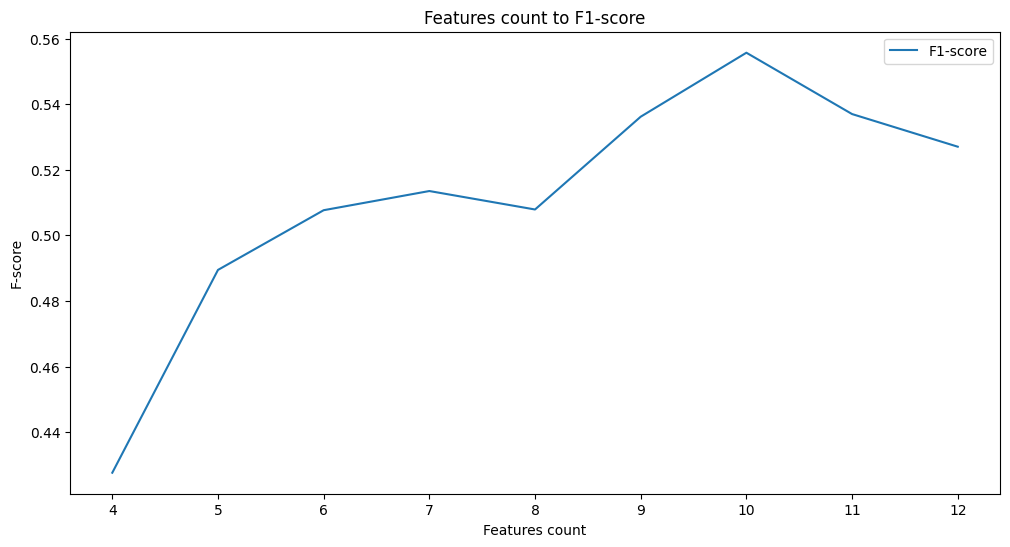

In [7]:
pipe = make_pipeline(
    SparsePCA(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sparsepca__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["sparsepca__n_components"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START kernelpca__n_components=4...................................
[CV 1/5; 1/9] END ....kernelpca__n_components=4;, score=0.386 total time=   0.1s
[CV 2/5; 1/9] START kernelpca__n_components=4...................................
[CV 2/5; 1/9] END ....kernelpca__n_components=4;, score=0.429 total time=   0.1s
[CV 3/5; 1/9] START kernelpca__n_components=4...................................
[CV 3/5; 1/9] END ....kernelpca__n_components=4;, score=0.425 total time=   0.1s
[CV 4/5; 1/9] START kernelpca__n_components=4...................................
[CV 4/5; 1/9] END ....kernelpca__n_components=4;, score=0.521 total time=   0.1s
[CV 5/5; 1/9] START kernelpca__n_components=4...................................
[CV 5/5; 1/9] END ....kernelpca__n_components=4;, score=0.505 total time=   0.1s
[CV 1/5; 2/9] START kernelpca__n_components=5...................................
[CV 1/5; 2/9] END ....kernelpca__n_components=5;,

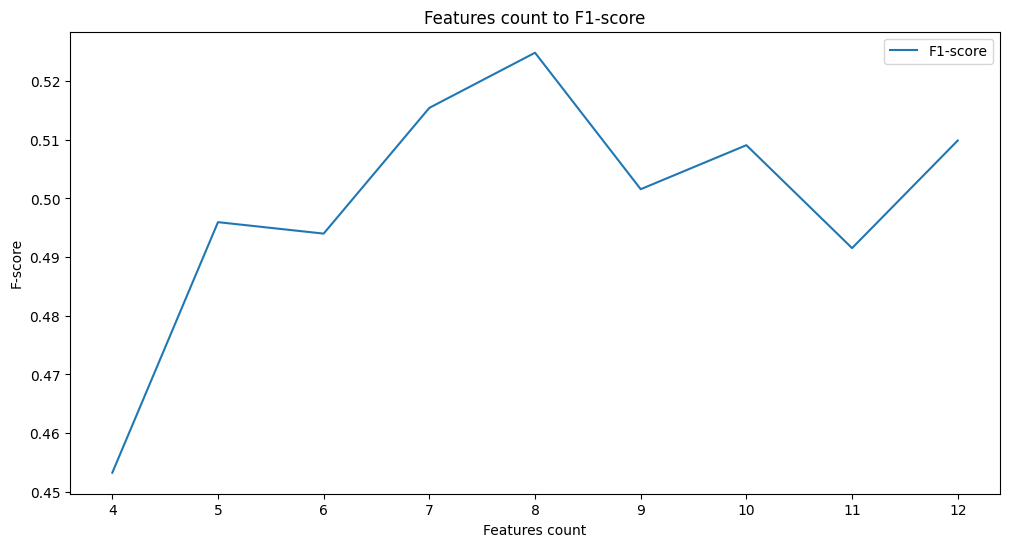

In [8]:
pipe = make_pipeline(
    KernelPCA(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "kernelpca__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["kernelpca__n_components"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dictionarylearning__n_components=4..........................
[CV 1/5; 1/9] END dictionarylearning__n_components=4;, score=0.388 total time=  17.4s
[CV 2/5; 1/9] START dictionarylearning__n_components=4..........................
[CV 2/5; 1/9] END dictionarylearning__n_components=4;, score=0.401 total time=  26.6s
[CV 3/5; 1/9] START dictionarylearning__n_components=4..........................
[CV 3/5; 1/9] END dictionarylearning__n_components=4;, score=0.460 total time=  32.4s
[CV 4/5; 1/9] START dictionarylearning__n_components=4..........................
[CV 4/5; 1/9] END dictionarylearning__n_components=4;, score=0.398 total time=  32.3s
[CV 5/5; 1/9] START dictionarylearning__n_components=4..........................
[CV 5/5; 1/9] END dictionarylearning__n_components=4;, score=0.377 total time=  21.8s
[CV 1/5; 2/9] START dictionarylearning__n_components=5..........................
[CV 1/5; 2/9] END dictio

/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=4.325e-01, previous alpha=3.250e-01, with an active set of 4 regressors.
  warnings.warn(


[CV 2/5; 2/9] END dictionarylearning__n_components=5;, score=0.371 total time=   4.8s
[CV 3/5; 2/9] START dictionarylearning__n_components=5..........................
[CV 3/5; 2/9] END dictionarylearning__n_components=5;, score=0.144 total time=  34.3s
[CV 4/5; 2/9] START dictionarylearning__n_components=5..........................
[CV 4/5; 2/9] END dictionarylearning__n_components=5;, score=0.427 total time=  26.0s
[CV 5/5; 2/9] START dictionarylearning__n_components=5..........................
[CV 5/5; 2/9] END dictionarylearning__n_components=5;, score=0.210 total time=   8.3s
[CV 1/5; 3/9] START dictionarylearning__n_components=6..........................
[CV 1/5; 3/9] END dictionarylearning__n_components=6;, score=0.324 total time=  33.3s
[CV 2/5; 3/9] START dictionarylearning__n_components=6..........................
[CV 2/5; 3/9] END dictionarylearning__n_components=6;, score=0.379 total time=  10.6s
[CV 3/5; 3/9] START dictionarylearning__n_components=6.........................

/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=1.811e-01, previous alpha=1.811e-01, with an active set of 4 regressors.
  warnings.warn(


[CV 4/5; 6/9] END dictionarylearning__n_components=9;, score=0.444 total time=  28.0s
[CV 5/5; 6/9] START dictionarylearning__n_components=9..........................
[CV 5/5; 6/9] END dictionarylearning__n_components=9;, score=0.366 total time=  14.3s
[CV 1/5; 7/9] START dictionarylearning__n_components=10.........................
[CV 1/5; 7/9] END dictionarylearning__n_components=10;, score=0.325 total time=   6.2s
[CV 2/5; 7/9] START dictionarylearning__n_components=10.........................
[CV 2/5; 7/9] END dictionarylearning__n_components=10;, score=0.371 total time=  11.4s
[CV 3/5; 7/9] START dictionarylearning__n_components=10.........................
[CV 3/5; 7/9] END dictionarylearning__n_components=10;, score=0.381 total time=   3.1s
[CV 4/5; 7/9] START dictionarylearning__n_components=10.........................
[CV 4/5; 7/9] END dictionarylearning__n_components=10;, score=0.393 total time=  17.1s
[CV 5/5; 7/9] START dictionarylearning__n_components=10....................

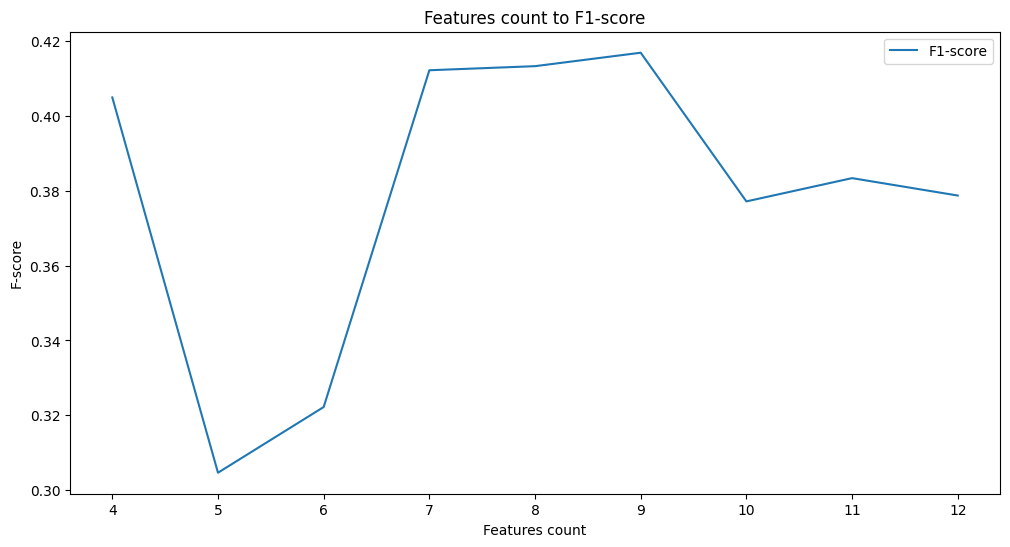

In [9]:
pipe = make_pipeline(
    DictionaryLearning(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "dictionarylearning__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["dictionarylearning__n_components"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START factoranalysis__n_components=4..............................
[CV 1/5; 1/9] END factoranalysis__n_components=4;, score=0.418 total time=   0.1s
[CV 2/5; 1/9] START factoranalysis__n_components=4..............................
[CV 2/5; 1/9] END factoranalysis__n_components=4;, score=0.440 total time=   0.1s
[CV 3/5; 1/9] START factoranalysis__n_components=4..............................
[CV 3/5; 1/9] END factoranalysis__n_components=4;, score=0.454 total time=   0.1s
[CV 4/5; 1/9] START factoranalysis__n_components=4..............................
[CV 4/5; 1/9] END factoranalysis__n_components=4;, score=0.540 total time=   0.1s
[CV 5/5; 1/9] START factoranalysis__n_components=4..............................
[CV 5/5; 1/9] END factoranalysis__n_components=4;, score=0.508 total time=   0.1s
[CV 1/5; 2/9] START factoranalysis__n_components=5..............................
[CV 1/5; 2/9] END factoranalysis__n_componen

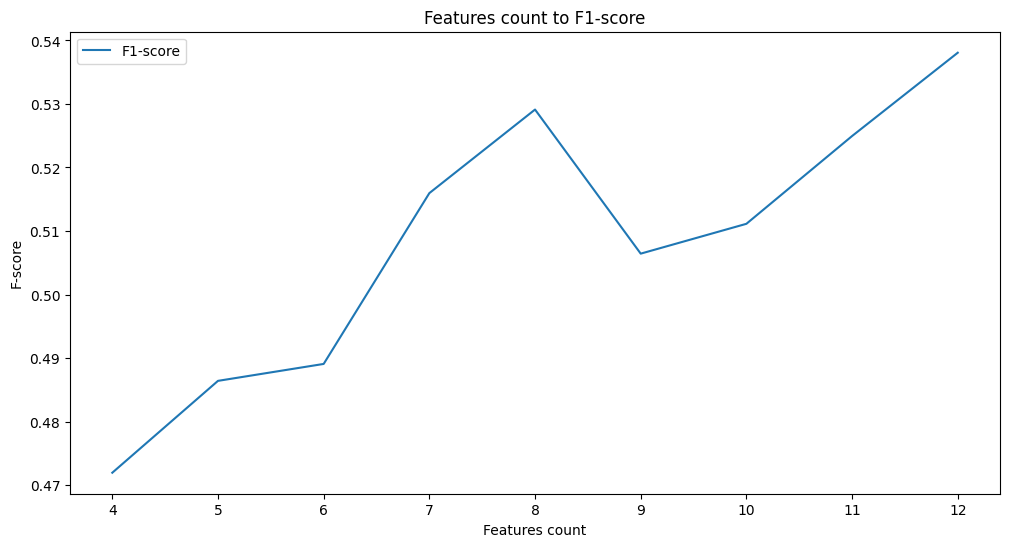

In [10]:
pipe = make_pipeline(
    FactorAnalysis(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "factoranalysis__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["factoranalysis__n_components"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START fastica__n_components=4.....................................
[CV 1/5; 1/9] END ......fastica__n_components=4;, score=0.426 total time=   0.1s
[CV 2/5; 1/9] START fastica__n_components=4.....................................
[CV 2/5; 1/9] END ......fastica__n_components=4;, score=0.484 total time=   0.1s
[CV 3/5; 1/9] START fastica__n_components=4.....................................
[CV 3/5; 1/9] END ......fastica__n_components=4;, score=0.438 total time=   0.1s
[CV 4/5; 1/9] START fastica__n_components=4.....................................
[CV 4/5; 1/9] END ......fastica__n_components=4;, score=0.488 total time=   0.1s
[CV 5/5; 1/9] START fastica__n_components=4.....................................
[CV 5/5; 1/9] END ......fastica__n_components=4;, score=0.438 total time=   0.1s
[CV 1/5; 2/9] START fastica__n_components=5.....................................
[CV 1/5; 2/9] END ......fastica__n_components=5;,

/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 4/5; 2/9] END ......fastica__n_components=5;, score=0.450 total time=   0.1s
[CV 5/5; 2/9] START fastica__n_components=5.....................................
[CV 5/5; 2/9] END ......fastica__n_components=5;, score=0.506 total time=   0.1s
[CV 1/5; 3/9] START fastica__n_components=6.....................................
[CV 1/5; 3/9] END ......fastica__n_components=6;, score=0.529 total time=   0.1s
[CV 2/5; 3/9] START fastica__n_components=6.....................................
[CV 2/5; 3/9] END ......fastica__n_components=6;, score=0.554 total time=   0.1s
[CV 3/5; 3/9] START fastica__n_components=6.....................................
[CV 3/5; 3/9] END ......fastica__n_components=6;, score=0.519 total time=   0.1s
[CV 4/5; 3/9] START fastica__n_components=6.....................................
[CV 4/5; 3/9] END ......fastica__n_components=6;, score=0.490 total time=   0.1s
[CV 5/5; 3/9] START fastica__n_components=6.....................................
[CV 5/5; 3/9] END ......fast

/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 1/5; 4/9] END ......fastica__n_components=7;, score=0.515 total time=   0.1s
[CV 2/5; 4/9] START fastica__n_components=7.....................................
[CV 2/5; 4/9] END ......fastica__n_components=7;, score=0.652 total time=   0.1s
[CV 3/5; 4/9] START fastica__n_components=7.....................................
[CV 3/5; 4/9] END ......fastica__n_components=7;, score=0.498 total time=   0.1s
[CV 4/5; 4/9] START fastica__n_components=7.....................................
[CV 4/5; 4/9] END ......fastica__n_components=7;, score=0.571 total time=   0.1s
[CV 5/5; 4/9] START fastica__n_components=7.....................................
[CV 5/5; 4/9] END ......fastica__n_components=7;, score=0.483 total time=   0.1s
[CV 1/5; 5/9] START fastica__n_components=8.....................................


/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 1/5; 5/9] END ......fastica__n_components=8;, score=0.478 total time=   0.1s
[CV 2/5; 5/9] START fastica__n_components=8.....................................
[CV 2/5; 5/9] END ......fastica__n_components=8;, score=0.547 total time=   0.1s
[CV 3/5; 5/9] START fastica__n_components=8.....................................
[CV 3/5; 5/9] END ......fastica__n_components=8;, score=0.497 total time=   0.1s
[CV 4/5; 5/9] START fastica__n_components=8.....................................
[CV 4/5; 5/9] END ......fastica__n_components=8;, score=0.475 total time=   0.1s
[CV 5/5; 5/9] START fastica__n_components=8.....................................
[CV 5/5; 5/9] END ......fastica__n_components=8;, score=0.449 total time=   0.1s
[CV 1/5; 6/9] START fastica__n_components=9.....................................
[CV 1/5; 6/9] END ......fastica__n_components=9;, score=0.563 total time=   0.1s
[CV 2/5; 6/9] START fastica__n_components=9.....................................
[CV 2/5; 6/9] END ......fast

/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 4/5; 6/9] END ......fastica__n_components=9;, score=0.444 total time=   0.1s
[CV 5/5; 6/9] START fastica__n_components=9.....................................
[CV 5/5; 6/9] END ......fastica__n_components=9;, score=0.492 total time=   0.1s
[CV 1/5; 7/9] START fastica__n_components=10....................................
[CV 1/5; 7/9] END .....fastica__n_components=10;, score=0.535 total time=   0.1s
[CV 2/5; 7/9] START fastica__n_components=10....................................


/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 2/5; 7/9] END .....fastica__n_components=10;, score=0.524 total time=   0.1s
[CV 3/5; 7/9] START fastica__n_components=10....................................
[CV 3/5; 7/9] END .....fastica__n_components=10;, score=0.431 total time=   0.1s
[CV 4/5; 7/9] START fastica__n_components=10....................................
[CV 4/5; 7/9] END .....fastica__n_components=10;, score=0.473 total time=   0.1s
[CV 5/5; 7/9] START fastica__n_components=10....................................


/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 5/5; 7/9] END .....fastica__n_components=10;, score=0.503 total time=   0.1s
[CV 1/5; 8/9] START fastica__n_components=11....................................
[CV 1/5; 8/9] END .....fastica__n_components=11;, score=0.534 total time=   0.1s
[CV 2/5; 8/9] START fastica__n_components=11....................................
[CV 2/5; 8/9] END .....fastica__n_components=11;, score=0.541 total time=   0.1s
[CV 3/5; 8/9] START fastica__n_components=11....................................


/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 3/5; 8/9] END .....fastica__n_components=11;, score=0.471 total time=   0.1s
[CV 4/5; 8/9] START fastica__n_components=11....................................
[CV 4/5; 8/9] END .....fastica__n_components=11;, score=0.486 total time=   0.1s
[CV 5/5; 8/9] START fastica__n_components=11....................................
[CV 5/5; 8/9] END .....fastica__n_components=11;, score=0.474 total time=   0.1s
[CV 1/5; 9/9] START fastica__n_components=12....................................
[CV 1/5; 9/9] END .....fastica__n_components=12;, score=0.526 total time=   0.1s
[CV 2/5; 9/9] START fastica__n_components=12....................................
[CV 2/5; 9/9] END .....fastica__n_components=12;, score=0.482 total time=   0.1s
[CV 3/5; 9/9] START fastica__n_components=12....................................
[CV 3/5; 9/9] END .....fastica__n_components=12;, score=0.471 total time=   0.1s
[CV 4/5; 9/9] START fastica__n_components=12....................................


/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/alexandermelashchenko/Workspace/intelligent-data-analysis/.venv/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[CV 4/5; 9/9] END .....fastica__n_components=12;, score=0.553 total time=   0.1s
[CV 5/5; 9/9] START fastica__n_components=12....................................
[CV 5/5; 9/9] END .....fastica__n_components=12;, score=0.483 total time=   0.1s


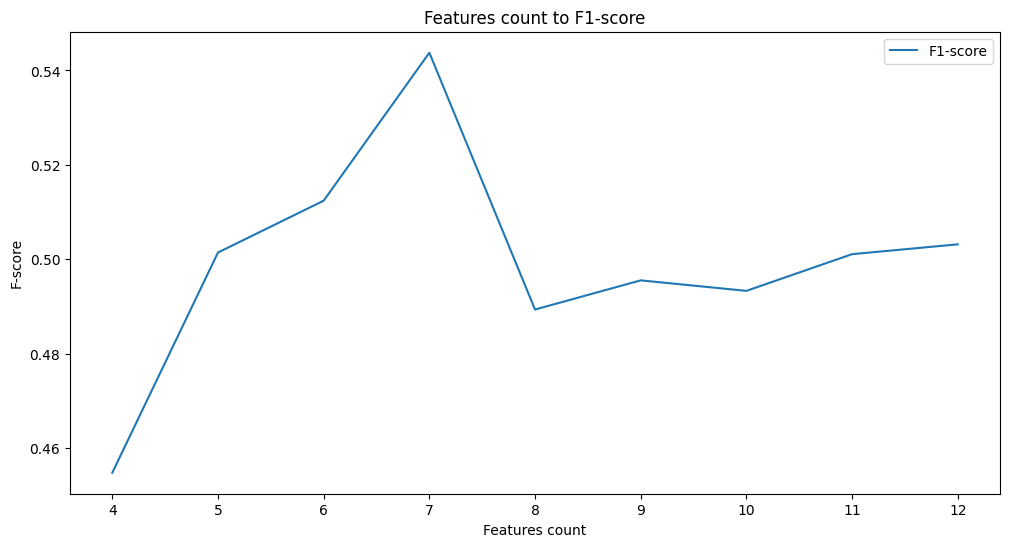

In [11]:
pipe = make_pipeline(
    FastICA(),
    StandardScaler(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "fastica__n_components": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["fastica__n_components"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

4. Виконати зниження розмірності набору даних, отримати суттєві ознаки (feature extraction), усунути шуми та ін. (залежно від обраної задачі), використовуючи
* Автокодувальник з лінійними функціями активації.
* Автокодувальник з нелінійними функціями активації.

In [12]:
scaler = StandardScaler()
x_scaled = torch.from_numpy(scaler.fit_transform(x))

In [13]:
autoencoder = AutoEncoder(features_count, 7)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
trainer = AutoEncoderTrainer(
    autoencoder,
    criterion,
    10_000,
    optimizer,
)

trainer.train(x_scaled)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
auto_encoded_x, _ = autoencoder(x_scaled)

model = RandomForestClassifier(random_state=random_seed)

cross_val_score(model, auto_encoded_x.detach().numpy(), y, scoring="f1_weighted").mean()

0.5249451042676638

In [15]:
autoencoder = LinearAutoEncoder(features_count, 7)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
trainer = AutoEncoderTrainer(
    autoencoder,
    criterion,
    10_000,
    optimizer,
)

trainer.train(x_scaled)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
auto_encoded_x, _ = autoencoder(x_scaled)

model = RandomForestClassifier(random_state=random_seed)

cross_val_score(model, auto_encoded_x.detach().numpy(), y, scoring="f1_weighted").mean()

0.5192023199864938

5. Порівняти результати за різними алгоритмами. Для обраної задачі використати всі наведені вище алгоритми.
Вказати які алгоритми дають кращі результати на обраному наборі даних. Чи є результати на основі автокодувальника з лінійними функціями активації близькими до результатів на основі методу PCA та інших з п.3?

6. Зробити висновки.

* Усі алгоритми показують більш менщ той самий результат ~ 0.52 ф1 скор, з ~ 7 ознаками. 
* Лінійний автоенкодер показує себе гірше ніж не лінійний. 
* Для цього датасету підхід вибору ознак показує кращий результат.
* DictionaryLearning займає набагато більше часу ніж інші підходи.